In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 1
%aimport original.create_MFF_grid

In [3]:
import os
import logging

import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from original import better_MFF_database
from original.better_MFF_database import carve_confs
from original import Kernels
from original import GP_for_MFF

from m_ff.interpolation import Spline3D, Spline1D
import matplotlib.pyplot as plt

better_MFF_database.USE_ASAP = False
logging.basicConfig(level=logging.INFO)

In [4]:
# Parameters
directory = 'data/Fe_vac/'
r_cut = 4.45
sigma = 0.6
noise = 0.0001
ntest = 20



In [5]:
# ----------------------------------------
# Test a simple GP on the built database
# ----------------------------------------

# Parameters
# ntr = 100
ntr = 30
ntest = 10

# Get configurations and forces from file
confs = np.load(str(directory + 'confs_cut={:.2f}.npy'.format(r_cut)))
forces = np.load(str(directory + 'forces_cut={:.2f}.npy'.format(r_cut)))
numconfs = len(forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

# Use fixed training and testing dataset
tr_confs, tr_forces = confs[:ntr], forces[:ntr]
tst_confs, tst_forces = confs[-ntest - 1:-1], forces[-ntest - 1:-1]


In [6]:
# Then train with a 3 body 
ker_3 = Kernels.ThreeBodySingleSpecies(theta=[sigma, r_cut / 10.0, r_cut])
gp_3 = GP_for_MFF.GaussianProcess(kernel=ker_3, noise=noise, optimizer=None)

print('Training 3B GP')
gp_3.fit(tr_confs, tr_forces)


Started compilation of theano three body single species kernels
Ended compilation of theano three body single species kernels
Training 3B GP


In [7]:
# Test the GP performance
print('Testing GP')

gp_3b_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))

for i in np.arange(ntest):
    gp_3b_forces[i, :] = gp_3.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_3b_forces[i, :] - tst_forces[i, :]

MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))


Testing GP
MAEF on forces: 0.1295 +- 0.0910
Relative MAEF on forces: 0.1608 +- 0.1130


In [9]:
# ----------------------------------------
# Mapping
# ----------------------------------------
import original.create_MFF_grid as create_MFF_grid
num = 20
grid_start = 1.5
elementslist = [26]

mapping_3b = create_MFF_grid.SingleSpecies(gp_3, grid_start, r_cut, num, elementslist[0], build2donly=False)
all_grids_3b = mapping_3b.build_grids()

grid_3b = Spline3D(all_grids_3b[0], all_grids_3b[0], all_grids_3b[0], all_grids_3b[4])

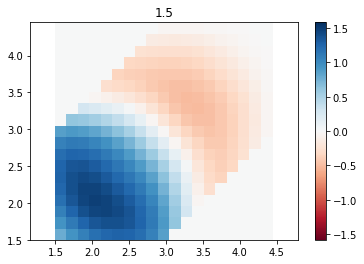

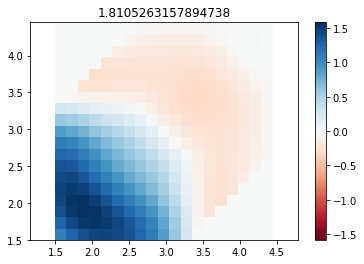

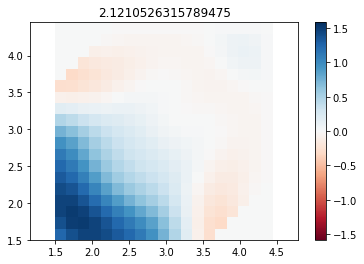

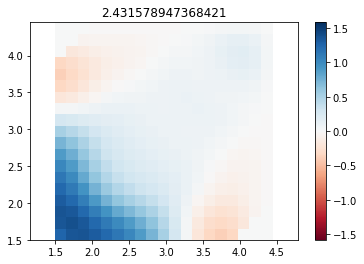

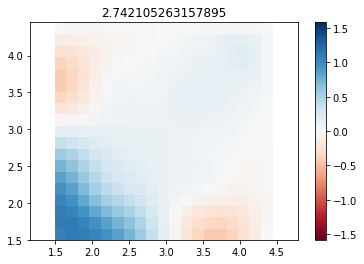

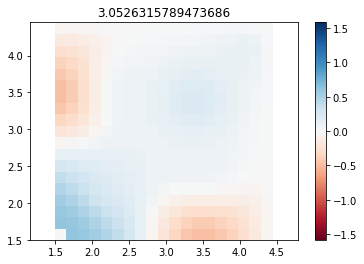

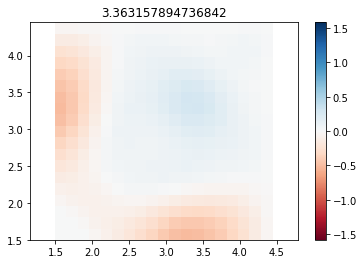

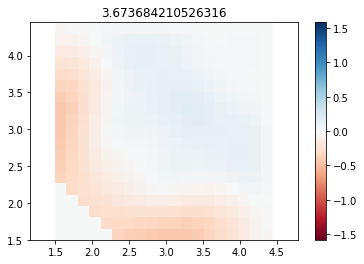

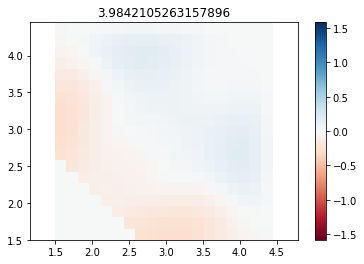

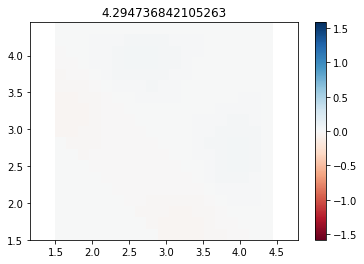

In [10]:
data=all_grids_3b[4]
dists=np.linspace(grid_start, r_cut, num)
z_min, z_max = -np.max(np.abs(data)), np.max(np.abs(data))
for i in range(0, len(dists), 2):
    plt.title(dists[i])
    plt.pcolor(dists, dists, -data[:,:,i], cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar()
    plt.axis('equal')

    plt.show()

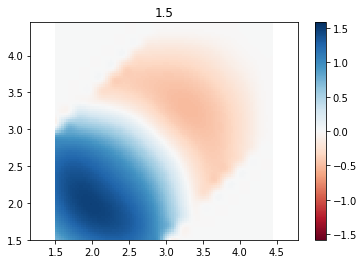

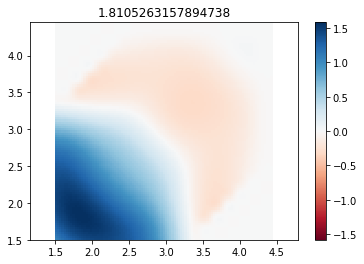

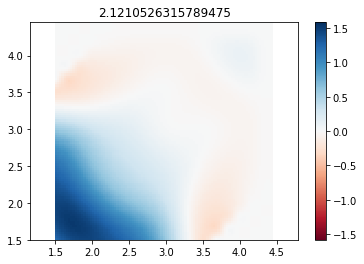

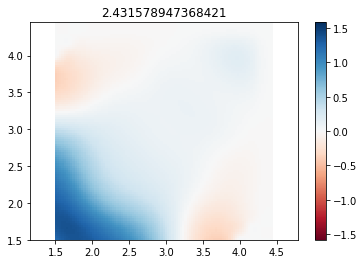

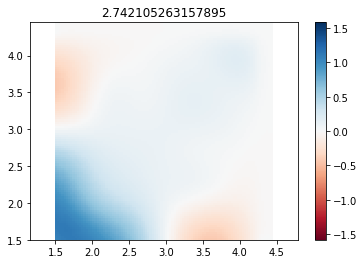

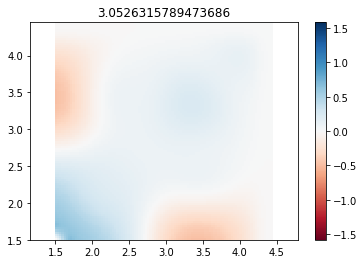

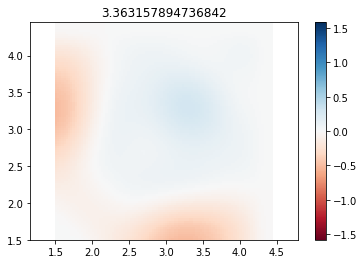

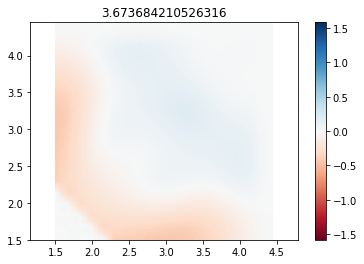

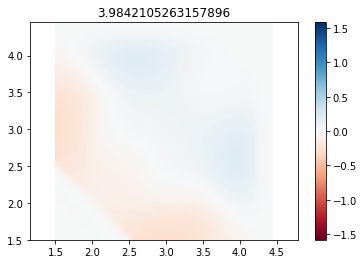

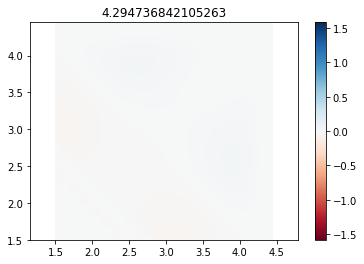

In [11]:
dist_range = np.linspace(grid_start, r_cut, 100)
for i in range(0, len(dists), 2):
    plt.title(dists[i])
    
    X, Y = np.meshgrid(dist_range, dist_range)
    g_data = grid_3b.ev_energy(X.flatten(), Y.flatten(), np.ones_like(X.flatten()) * dists[i]).reshape(100,100)
    plt.pcolor(dist_range, dist_range, -g_data, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar()
    plt.axis('equal')

    plt.show()

In [12]:
d_ij, d_jk, d_ki =  3.053,3.0,3.208

(grid_3b.ev_all(d_ij, d_jk, d_ki), 
 grid_3b.ev_all(d_ij, d_ki, d_jk),
 grid_3b.ev_all(d_jk, d_ij, d_ki),
 grid_3b.ev_all(d_ki, d_ij, d_jk),
 grid_3b.ev_all(d_jk, d_ki, d_ij),
 grid_3b.ev_all(d_ki, d_jk, d_ij)) 

((array([[-0.173]]), array([[-0.236]]), array([[-0.304]]), array([[-0.078]])),
 (array([[-0.173]]), array([[-0.236]]), array([[-0.078]]), array([[-0.304]])),
 (array([[-0.173]]), array([[-0.304]]), array([[-0.236]]), array([[-0.078]])),
 (array([[-0.173]]), array([[-0.078]]), array([[-0.236]]), array([[-0.304]])),
 (array([[-0.173]]), array([[-0.304]]), array([[-0.078]]), array([[-0.236]])),
 (array([[-0.173]]), array([[-0.078]]), array([[-0.304]]), array([[-0.236]])))

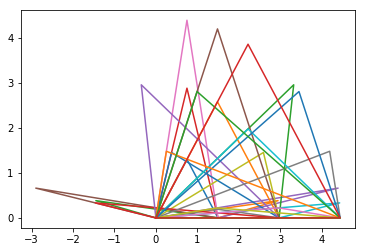

In [13]:
dists = np.linspace(grid_start, r_cut, 3)
inds, r1_x, r2_x, r2_y = mapping_3b.generate_triplets(dists)

for i in range(len(r1_x)):
    plt.plot([0,r1_x[i],r2_x[i],0], [0,0,r2_y[i],0])

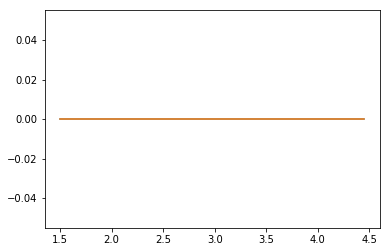

In [14]:
plt.plot(all_grids_3b[0], -all_grids_3b[3])

mapped_3b = Spline1D(all_grids_3b[0],all_grids_3b[3])

r = np.linspace(1.5,4.45,1000)
plt.plot(r, mapped_3b(r, nu=0))
